# Doing Bayesian Data Analysis

An example from __Chapter 19__.

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

# Kruschke's light blue color
sns.set_palette(["#87ceeb", "#0c62c4", "#f3ae09", "#399f34", "#fd0607"])
sns.set_context("talk")

In [11]:
df = pd.read_csv("data/FruitflyDataReduced.csv")
df.CompanionNumber = df.CompanionNumber.astype("category")
print df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.2 KB
None


,Longevity,CompanionNumber,Thorax
0,35,Pregnant8,0.64
1,37,Pregnant8,0.68
2,49,Pregnant8,0.68
3,46,Pregnant8,0.72
4,63,Pregnant8,0.72


In [12]:
df.groupby("CompanionNumber").head(2)

,Longevity,CompanionNumber,Thorax
0,35,Pregnant8,0.64
1,37,Pregnant8,0.68
25,40,None0,0.64
26,37,None0,0.70
50,46,Pregnant1,0.64
51,42,Pregnant1,0.68
75,21,Virgin1,0.68
76,40,Virgin1,0.68
100,16,Virgin8,0.64
101,19,Virgin8,0.64


In [13]:
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

![Ch 19 Model](images/19_2.png)

In [16]:
X = df.CompanionNumber.cat.codes.values
y = df.Longevity
zy = (y - y.mean()) / y.std()

In [17]:
n_cols = len(df.CompanionNumber.cat.categories)
with pm.Model() as model:
    # Priors
    sigma_0 = pm.HalfCauchy("sigma_0", 25)
    beta_0 = pm.Normal("beta_0", mu=0, sd=sigma_0)
    
    sigma_j = pm.HalfCauchy("sigma_j", 25)
    beta_j = pm.Normal("beta_j", mu=0, sd=sigma_j, shape=n_cols)
    
    theta = beta_0 + beta_j[X]
    sigma = pm.HalfCauchy("sigma", 25)

    # Likelihood
    y = pm.Normal("y", mu=theta, sd=sigma, observed=y)

    # Sample
    trace = pm.sample(10000)
    
burn_in = 5000
trace = trace[burn_in:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -534.52: 100%|██████████| 200000/200000 [00:21<00:00, 9474.09it/s] 
Finished [100%]: Average ELBO = -534.5
100%|██████████| 10000/10000 [00:24<00:00, 400.48it/s]


                mean          sd  mc_error    hpd_2.5    hpd_97.5
beta_0     55.889453    8.089477  0.426392  38.341149   71.474172
beta_j__0   7.303877    8.502194  0.424899 -11.497753   23.254718
beta_j__1   8.419922    8.429409  0.421172  -8.383223   25.990456
beta_j__2   7.059094    8.461961  0.431132 -11.899080   22.818078
beta_j__3   0.857385    8.320754  0.422083 -15.797377   18.571231
beta_j__4 -15.973245    8.318457  0.427177 -33.434247    0.630314
sigma_0    87.731682  212.361492  4.785914  12.591432  228.521634
sigma_j    14.527582    7.555040  0.284585   4.908179   28.418658
sigma      14.953403    0.985475  0.014046  13.164081   16.978985


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11df26c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119b36650>]], dtype=object)

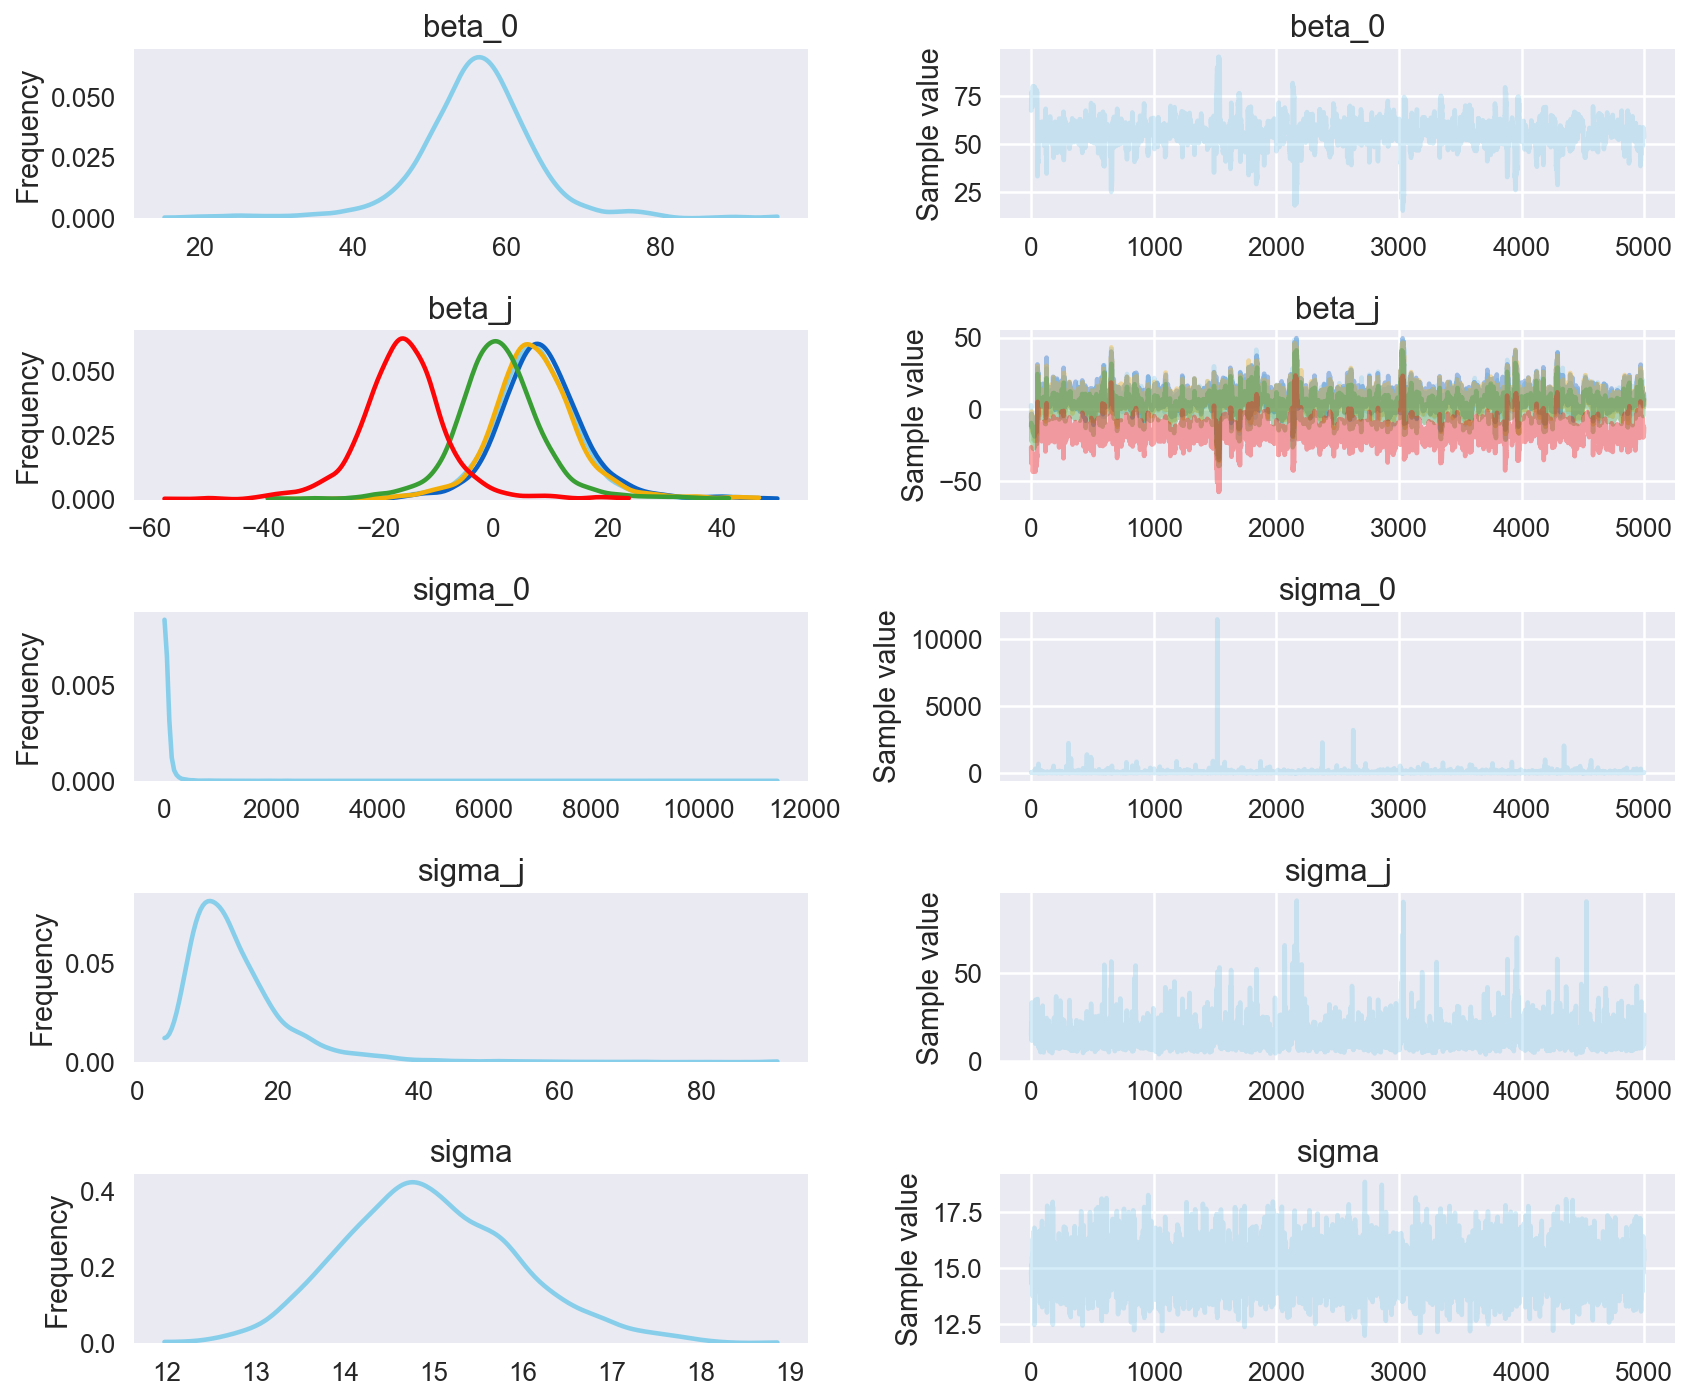

In [24]:
print(pm.df_summary(trace))
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a724250>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11b474210>], dtype=object)

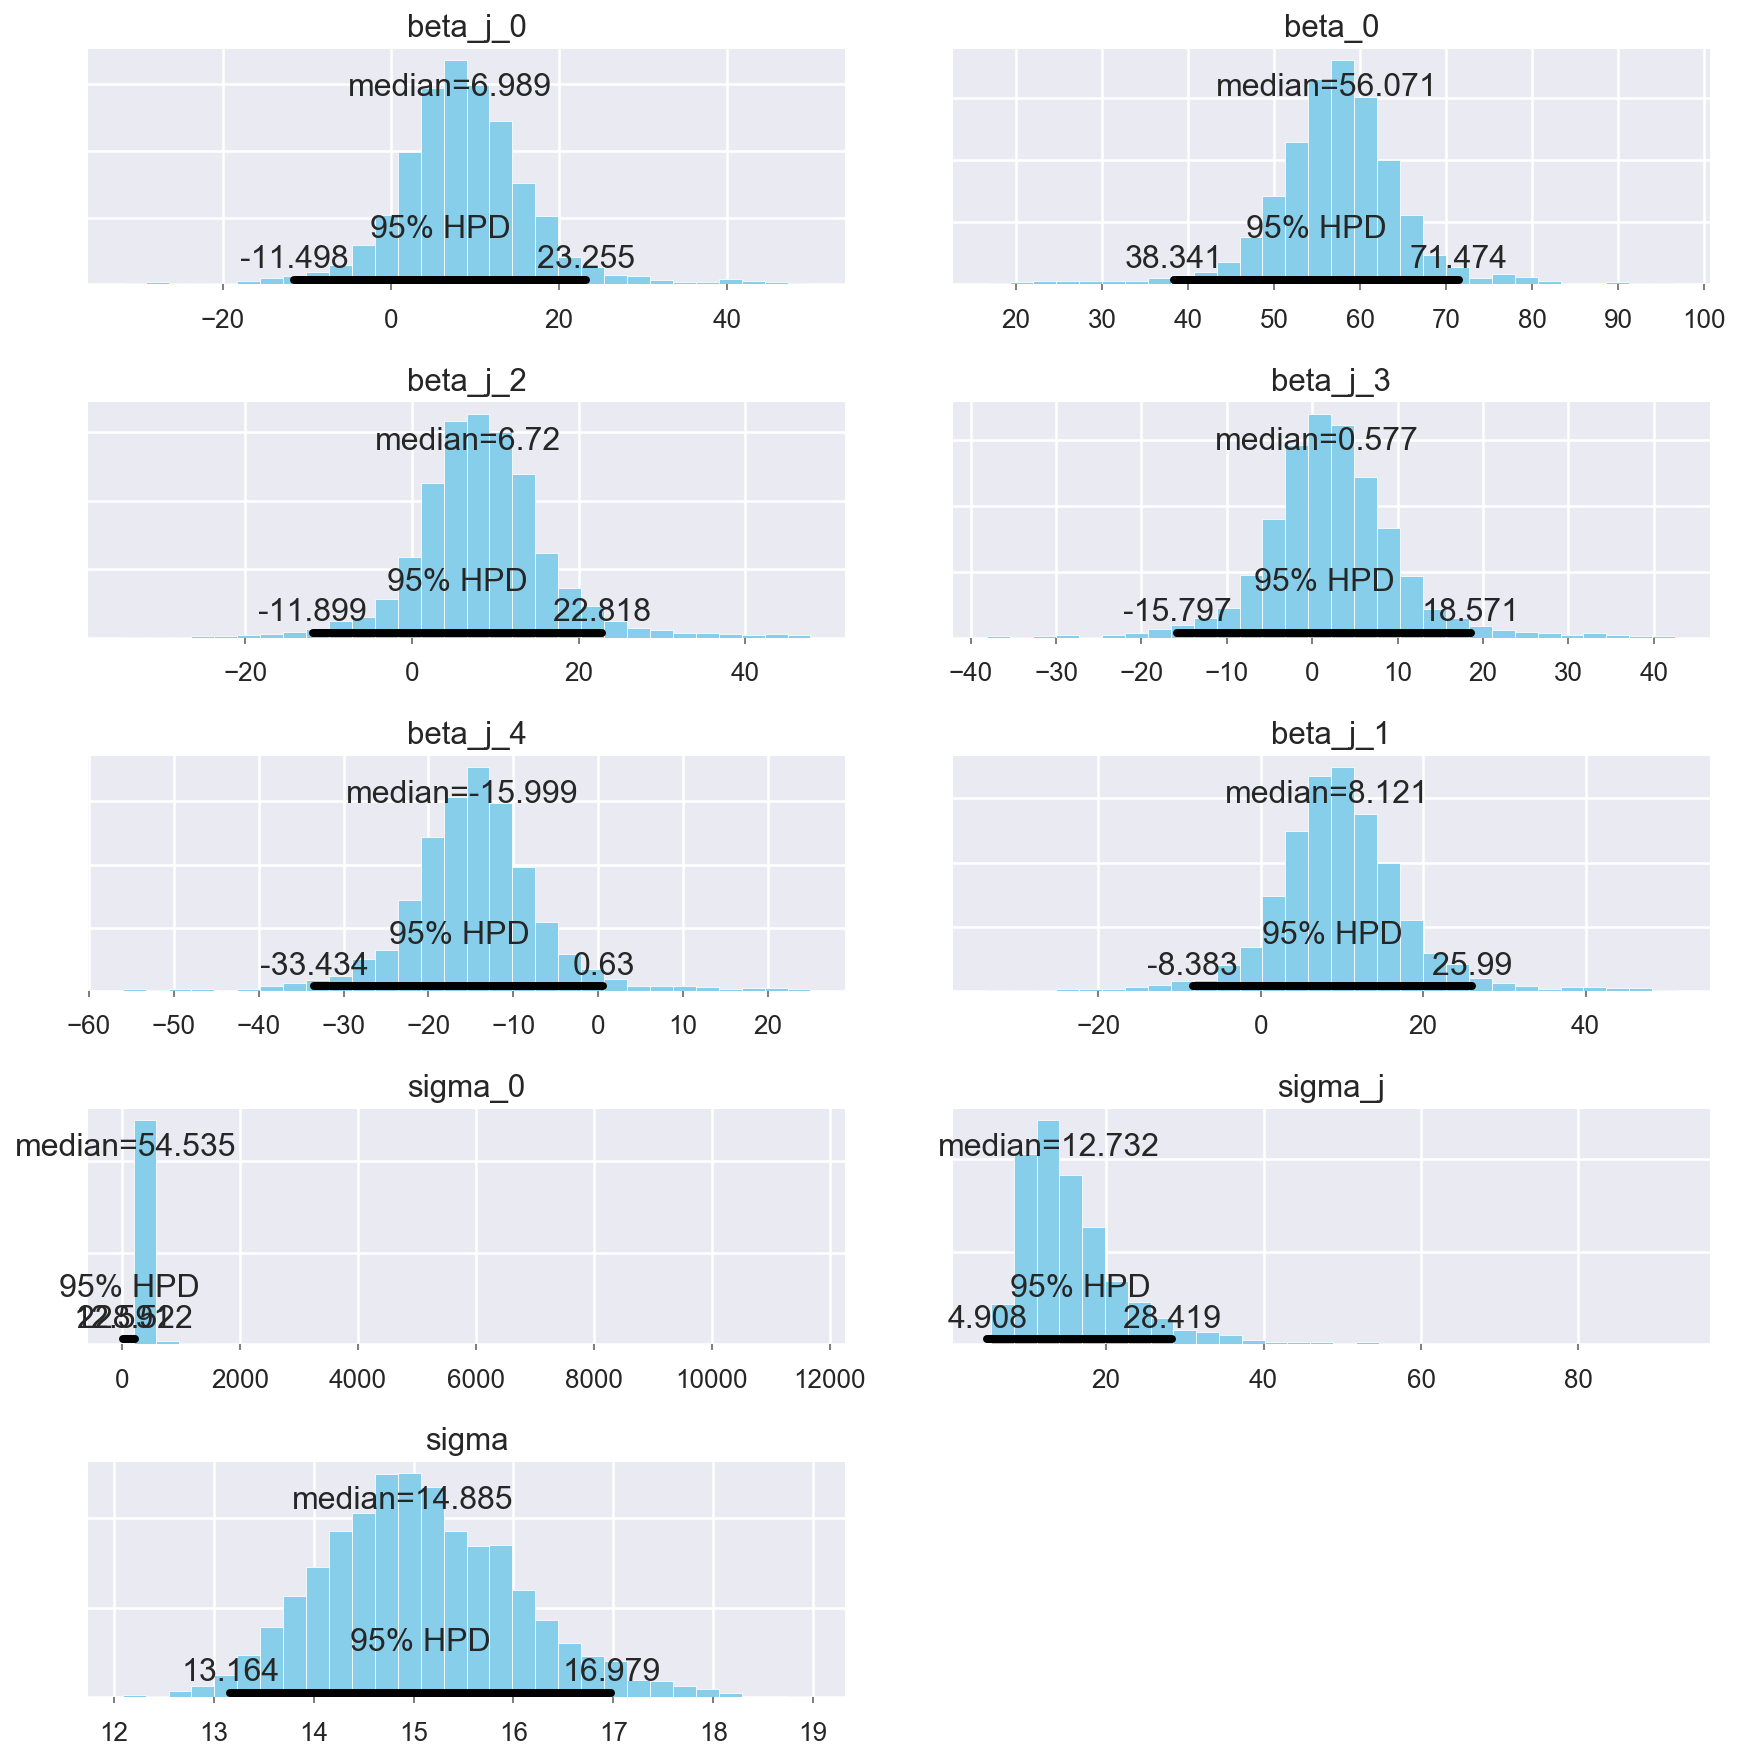

In [19]:
pm.plot_posterior(trace, point_estimate="median")

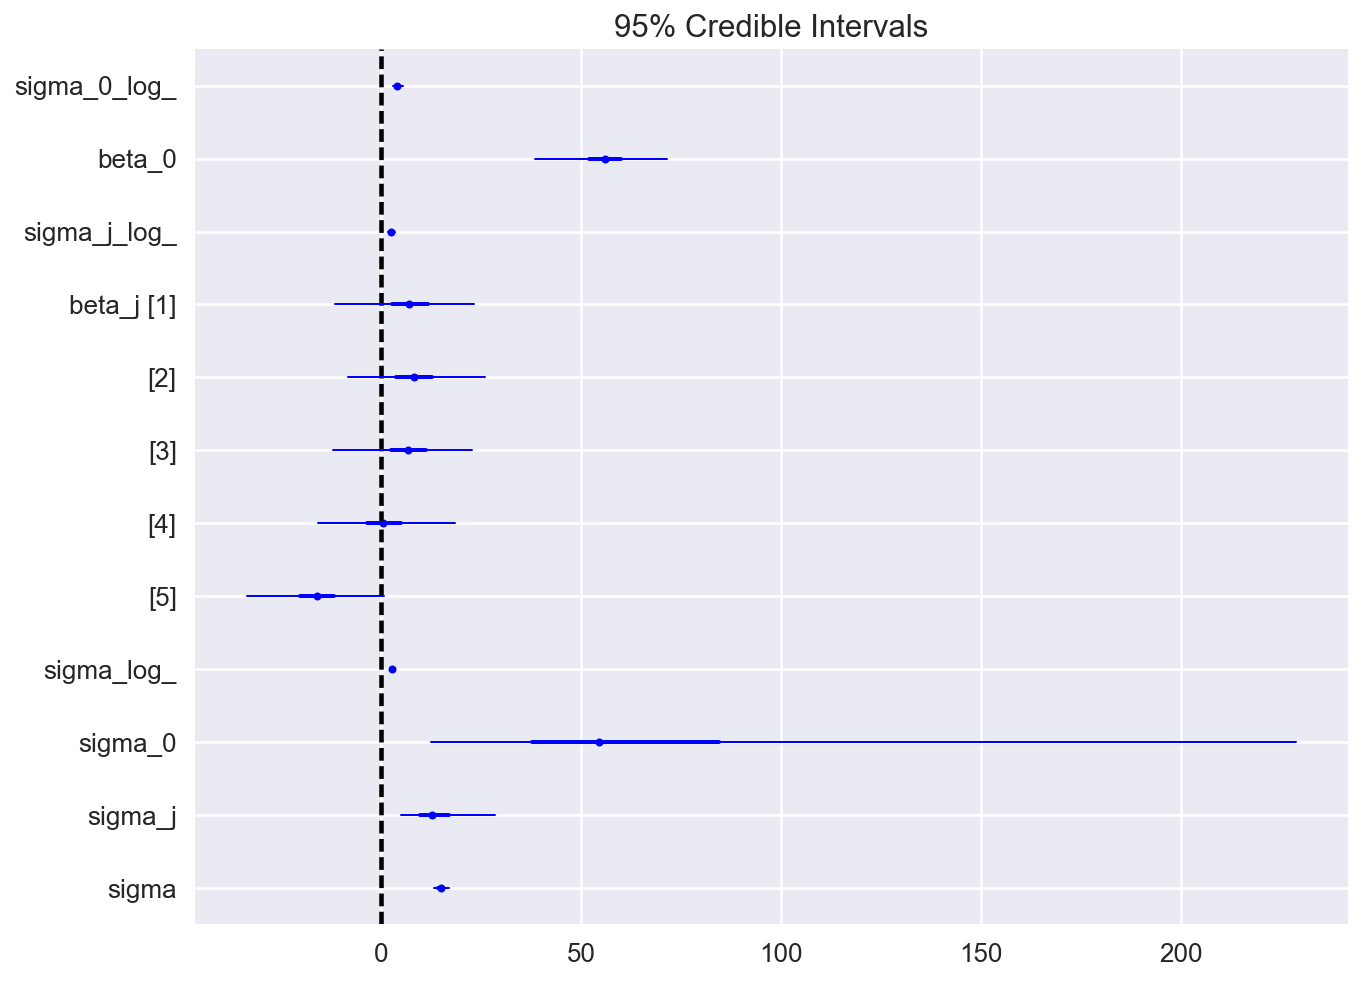

In [21]:
pm.forestplot(trace)

In [22]:
def plot_mustache(var, sd, j, width=.75):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = st.norm(loc=var[i], scale=sd[i])
        y_range = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        x_range = rv.pdf(y_range)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = x_range * (width / x_range.max())
        
        # Using the negative value to flip the mustache in the right direction.
        plt.plot(-x_range_scaled + j, y_range, color="#87ceeb", alpha=.6)